In [1]:
!python -V

Python 3.9.19


In [44]:
import pandas as pd

In [45]:
import pickle

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [48]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/learn-mlops/02-experiment-tracking/mlruns/1', creation_time=1717029414367, experiment_id='1', last_update_time=1717029414367, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [49]:
df = pd.read_parquet('./data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [50]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

2024/05/30 01:46:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7e69ef9a028e4931bcc8ad2bca651555', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/30 01:46:18 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/05/30 01:46:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils."


7.060351536580523

/tmp/ipykernel_6349/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_6349/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


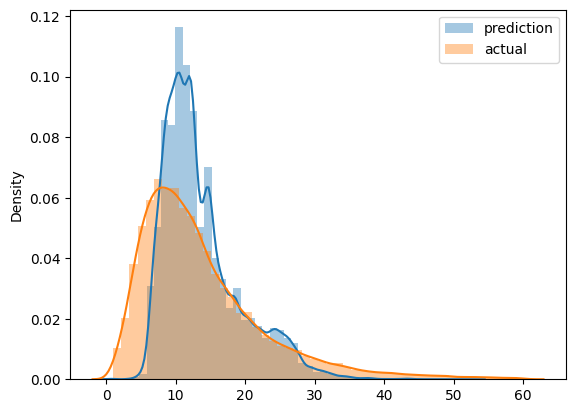

In [51]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [52]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [53]:
df_train = read_dataframe('./data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2023-02.parquet')

In [54]:
len(df_train), len(df_val)

(65946, 62574)

In [55]:

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [56]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [57]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

2024/05/30 01:46:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '35088658165141f7adcc67710058ca43', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/30 01:46:34 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


6.037803764245777

In [59]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [29]:
with mlflow.start_run():

    mlflow.set_tag("developer", "cristian")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2023-02.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [33]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [36]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [41]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                                                         | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:25:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.07421                                                                                                                          
[1]	validation-rmse:5.48315                                                                                                                          
[2]	validation-rmse:5.37810                                                                                                                          
[3]	validation-rmse:5.34838                                                                                                                          
[4]	validation-rmse:5.34050                                                                                                                          
[5]	validation-rmse:5.33324                                                                                                                          
[6]	validation-rmse:5.32639                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:25:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.65888                                                                                                                          
[1]	validation-rmse:5.69227                                                                                                                          
[2]	validation-rmse:5.37336                                                                                                                          
[3]	validation-rmse:5.27186                                                                                                                          
[4]	validation-rmse:5.22638                                                                                                                          
[5]	validation-rmse:5.20567                                                                                                                          
[6]	validation-rmse:5.20064                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.93880                                                                                                                          
[1]	validation-rmse:8.58673                                                                                                                          
[2]	validation-rmse:8.26500                                                                                                                          
[3]	validation-rmse:7.97105                                                                                                                          
[4]	validation-rmse:7.70232                                                                                                                          
[5]	validation-rmse:7.45705                                                                                                                          
[6]	validation-rmse:7.23434                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.57516                                                                                                                          
[1]	validation-rmse:5.25182                                                                                                                          
[2]	validation-rmse:5.22585                                                                                                                          
[3]	validation-rmse:5.20962                                                                                                                          
[4]	validation-rmse:5.20585                                                                                                                          
[5]	validation-rmse:5.19500                                                                                                                          
[6]	validation-rmse:5.19102                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:28:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.96044                                                                                                                          
[1]	validation-rmse:5.96197                                                                                                                          
[2]	validation-rmse:5.58202                                                                                                                          
[3]	validation-rmse:5.41756                                                                                                                          
[4]	validation-rmse:5.36355                                                                                                                          
[5]	validation-rmse:5.32100                                                                                                                          
[6]	validation-rmse:5.30828                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:28:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.43800                                                                                                                          
[1]	validation-rmse:5.54261                                                                                                                          
[2]	validation-rmse:5.29096                                                                                                                          
[3]	validation-rmse:5.21788                                                                                                                          
[4]	validation-rmse:5.19230                                                                                                                          
[5]	validation-rmse:5.17952                                                                                                                          
[6]	validation-rmse:5.17392                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:28:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.20624                                                                                                                          
[1]	validation-rmse:7.36264                                                                                                                          
[2]	validation-rmse:6.73389                                                                                                                          
[3]	validation-rmse:6.28332                                                                                                                          
[4]	validation-rmse:5.95329                                                                                                                          
[5]	validation-rmse:5.72565                                                                                                                          
[6]	validation-rmse:5.56344                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:29:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.67720                                                                                                                          
[1]	validation-rmse:6.67655                                                                                                                          
[2]	validation-rmse:6.09704                                                                                                                          
[3]	validation-rmse:5.75961                                                                                                                          
[4]	validation-rmse:5.54955                                                                                                                          
[5]	validation-rmse:5.44484                                                                                                                          
[6]	validation-rmse:5.37872                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:30:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.72002                                                                                                                          
[1]	validation-rmse:5.46184                                                                                                                          
[2]	validation-rmse:5.39540                                                                                                                          
[3]	validation-rmse:5.36819                                                                                                                          
[4]	validation-rmse:5.34758                                                                                                                          
[5]	validation-rmse:5.34019                                                                                                                          
[6]	validation-rmse:5.33729                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:30:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.83695                                                                                                                          
[1]	validation-rmse:5.90088                                                                                                                          
[2]	validation-rmse:5.58133                                                                                                                          
[3]	validation-rmse:5.46637                                                                                                                          
[4]	validation-rmse:5.40481                                                                                                                          
[5]	validation-rmse:5.36487                                                                                                                          
[6]	validation-rmse:5.34900                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:31:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.59595                                                                                                                          
[1]	validation-rmse:5.32277                                                                                                                          
[2]	validation-rmse:5.28003                                                                                                                          
[3]	validation-rmse:5.26599                                                                                                                          
[4]	validation-rmse:5.23794                                                                                                                          
[5]	validation-rmse:5.23259                                                                                                                          
[6]	validation-rmse:5.22956                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:31:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.69582                                                                                                                          
[1]	validation-rmse:8.15957                                                                                                                          
[2]	validation-rmse:7.70015                                                                                                                          
[3]	validation-rmse:7.30676                                                                                                                          
[4]	validation-rmse:6.97625                                                                                                                          
[5]	validation-rmse:6.69800                                                                                                                          
[6]	validation-rmse:6.46017                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:32:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.31247                                                                                                                          
[1]	validation-rmse:6.23413                                                                                                                          
[2]	validation-rmse:5.69314                                                                                                                          
[3]	validation-rmse:5.43336                                                                                                                          
[4]	validation-rmse:5.30480                                                                                                                          
[5]	validation-rmse:5.23995                                                                                                                          
[6]	validation-rmse:5.20876                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:32:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.36816                                                                                                                          
[1]	validation-rmse:7.61298                                                                                                                          
[2]	validation-rmse:7.02413                                                                                                                          
[3]	validation-rmse:6.57013                                                                                                                          
[4]	validation-rmse:6.22537                                                                                                                          
[5]	validation-rmse:5.96581                                                                                                                          
[6]	validation-rmse:5.77305                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:34:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.05394                                                                                                                          
[2]	validation-rmse:5.64523                                                                                                                          
[3]	validation-rmse:5.48239                                                                                                                          
[4]	validation-rmse:5.41132                                                                                                                          
[5]	validation-rmse:5.37290                                                                                                                          
[6]	validation-rmse:5.35173                                                                                                                          
[7]	validation-rmse:5.34145                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:34:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.94607                                                                                                                          
[1]	validation-rmse:5.46429                                                                                                                          
[2]	validation-rmse:5.36814                                                                                                                          
[3]	validation-rmse:5.33136                                                                                                                          
[4]	validation-rmse:5.31576                                                                                                                          
[5]	validation-rmse:5.30540                                                                                                                          
[6]	validation-rmse:5.29277                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:35:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.64026                                                                                                                          
[1]	validation-rmse:6.61950                                                                                                                          
[2]	validation-rmse:6.02742                                                                                                                          
[3]	validation-rmse:5.69285                                                                                                                          
[4]	validation-rmse:5.52989                                                                                                                          
[5]	validation-rmse:5.44094                                                                                                                          
[6]	validation-rmse:5.37116                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:35:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.31594                                                                                                                          
[1]	validation-rmse:7.54890                                                                                                                          
[2]	validation-rmse:6.97283                                                                                                                          
[3]	validation-rmse:6.54657                                                                                                                          
[4]	validation-rmse:6.23422                                                                                                                          
[5]	validation-rmse:6.00945                                                                                                                          
[6]	validation-rmse:5.84838                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:37:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.00580                                                                                                                          
[1]	validation-rmse:8.71219                                                                                                                          
[2]	validation-rmse:8.44000                                                                                                                          
[3]	validation-rmse:8.18790                                                                                                                          
[4]	validation-rmse:7.95482                                                                                                                          
[5]	validation-rmse:7.73952                                                                                                                          
[6]	validation-rmse:7.54097                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:39:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.73454                                                                                                                          
[1]	validation-rmse:5.31401                                                                                                                          
[2]	validation-rmse:5.24912                                                                                                                          
[3]	validation-rmse:5.22476                                                                                                                          
[4]	validation-rmse:5.21818                                                                                                                          
[5]	validation-rmse:5.21220                                                                                                                          
[6]	validation-rmse:5.20686                                                                         

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:39:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99854                                                                                                                          
[1]	validation-rmse:8.69795                                                                                                                          
[2]	validation-rmse:8.41979                                                                                                                          
[3]	validation-rmse:8.16207                                                                                                                          
[4]	validation-rmse:7.92480                                                                                                                          
[5]	validation-rmse:7.70481                                                                                                                          
[6]	validation-rmse:7.50287                                                                         

In [ ]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [60]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2023-01.parquet")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2023-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

FileNotFoundError: [Errno 2] No such file or directory: 'models/preprocessor.b'